# Transfer Learning with MobileNetV2

Transfer learning on a pre-trained CNN to build an Alpaca/Not Alpaca classifier!

<img src="images/alpaca.png" style="width:300px;height:220px;">

A pre-trained model is a network that's already been trained on a large dataset and saved, which allows you to use it to customize your own model cheaply and efficiently. The one you'll be using, MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

Key Steps:

- Create a dataset from a directory
- Preprocess and augment data using the Sequential API
- Adapt a pretrained model to new data and train a classifier using the Functional API and MobileNet
- Fine-tune a classifier's final layers to improve accuracy

In [44]:
!kaggle datasets download -d razmuhammad/dataset -p /content/dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/razmuhammad/dataset
License(s): CC0-1.0
 95% 132M/139M [00:01<00:00, 134MB/s]
100% 139M/139M [00:01<00:00, 122MB/s]


## 1 Packages

In [45]:
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
# Correct import for preprocessing layers
from tensorflow.keras.layers import RandomFlip, RandomRotation


In [46]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "/content/dataset/Files/W2A2/dataset"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


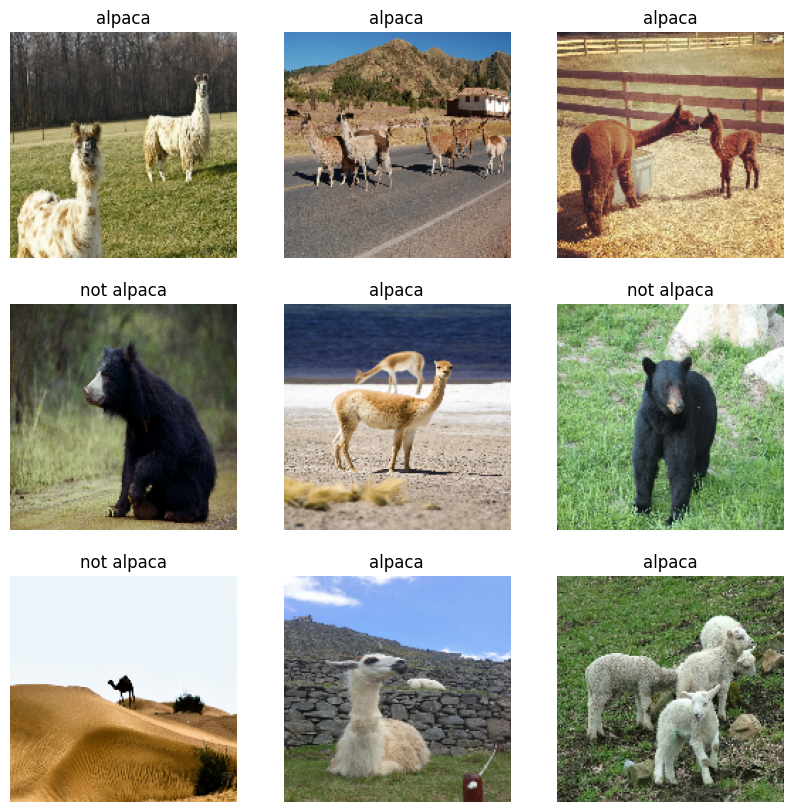

In [47]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 2 - Preprocess and Augment Training Data

In [48]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [49]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip('horizontal'),
            tf.keras.layers.RandomRotation(0.2)
    ])

    return data_augmentation


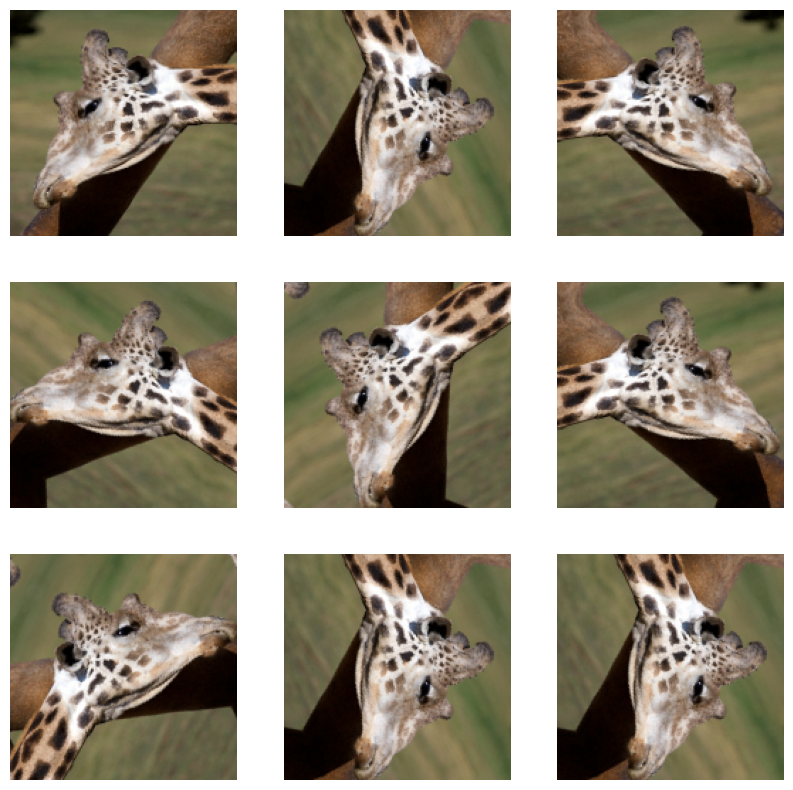

In [50]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [51]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<a name='3'></a>
## 3 - Using MobileNetV2 for Transfer Learning

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep (just in case you felt the urge to plot the model yourself, prepare for a long journey!) and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics:

*   Depthwise separable convolutions
*   Thin input and output bottlenecks between layers
*   Shortcut connections between bottleneck layers

<a name='3-1'></a>
### 3.1 - Inside a MobileNetV2 Convolutional Building Block

MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and  depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps:

1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution, or: **Shape of the depthwise convolution X Number of filters.**

<img src="images/mobilenetv2.png" style="width:650px;height:450px;">
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>MobileNetV2 Architecture</b> <br> This diagram was inspired by the original seen <a href="https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a%20significant%20improvement,object%20detection%20and%20semantic%20segmentation.">here</a>.</center></caption>

Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information.

The shortcut connections, which are similar to the ones in traditional residual networks, serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers.

In [52]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights="imagenet")

In [53]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [54]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d_2
predictions


In [55]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [56]:
#Shows the different label probabilities in one tensor
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

In [57]:
!wget https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json
import json


base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

# Function to decode predictions
def decode_predictions(preds, top=2):
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(class_index[str(i)]) + (pred[i],) for i in top_indices]
        results.append(result)
    return results

# Load the class index from the downloaded file
with open("imagenet_class_index.json", 'r') as f: # Changed the path to the correct location
    class_index = json.load(f)

decoded_predictions = decode_predictions(pred.numpy(), top=2)
print(decoded_predictions)

--2025-03-09 11:07:59--  https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [text/plain]
Saving to: ‘imagenet_class_index.json.1’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.007s  

2025-03-09 11:07:59 (4.98 MB/s) - ‘imagenet_class_index.json.1’ saved [35363/35363]

[[('n02489166', 'proboscis_monkey', 0.103300065), ('n02102177', 'Welsh_springer_spaniel', 0.078835346)], [('n02125311', 'cougar', 0.16546673), ('n02389026', 'sorrel', 0.10764271)], [('n02437312', 'Arabian_camel', 0.29232854), ('n02437616', 'llama', 0.27713612)], [('n03944341', 'pinwheel', 0.3115492), ('n03047690', 'clog', 0.052500002)], [('n02454379', 'armadillo',

In [58]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''


    input_shape = image_shape + (3,)
    base_model_path="imagenet"
    base_model = tf.keras.applications.MobileNetV2(input_shape= input_shape ,
                                                   include_top=False, # <== Important!!!!
                                                   weights=base_model_path)

    # freeze the base model by making it non trainable
    base_model.trainable = False
    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape )
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [59]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [60]:
base_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
model2.compile(optimizer = optimizer,
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
metrics=['accuracy'])

In [61]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 452ms/step - accuracy: 0.4528 - loss: 0.8300 - val_accuracy: 0.6154 - val_loss: 0.5310
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - accuracy: 0.6284 - loss: 0.6558 - val_accuracy: 0.6923 - val_loss: 0.4395
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.6766 - loss: 0.5366 - val_accuracy: 0.7692 - val_loss: 0.3710
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.7130 - loss: 0.5277 - val_accuracy: 0.7846 - val_loss: 0.3345
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.8105 - loss: 0.4198 - val_accuracy: 0.8000 - val_loss: 0.2809


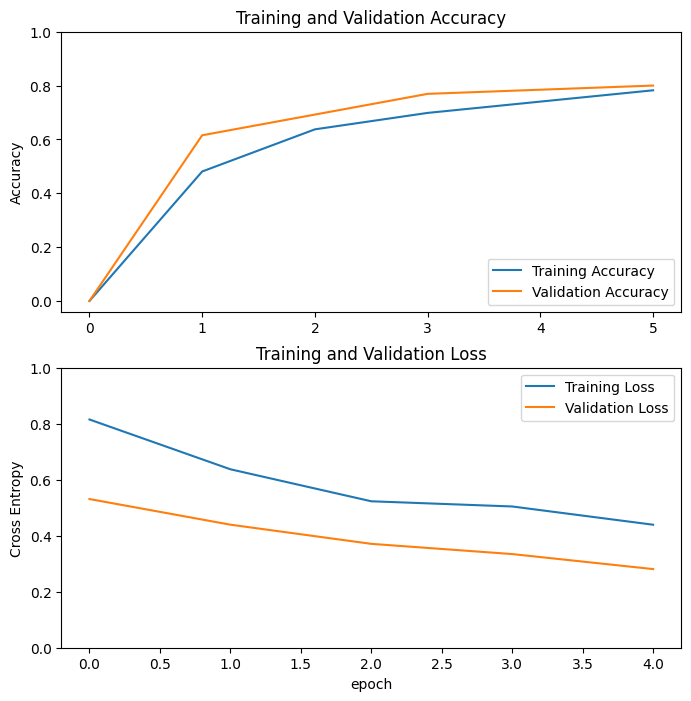

In [62]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### 4 - Fine-tuning the Model

You could try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. When you use a smaller learning rate, you take smaller steps to adapt it a little more closely to the new data. In transfer learning, the way you achieve this is by unfreezing the layers at the end of the network, and then re-training your model on the final layers with a very low learning rate. Adapting your learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

The intuition for what's happening: when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When you add new data, you generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to your data, such as soft fur or big teeth.

To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

Where the final layers actually begin is a bit arbitrary, so feel free to play around with this number a bit. The important takeaway is that the later layers are the part of your network that contain the fine details (pointy ears, hairy tails) that are more specific to your problem.

First, unfreeze the base model by setting `base_model.trainable=True`, set a layer to fine-tune from, then re-freeze all the layers before it. Run it again for another few epochs, and see if your accuracy improved!

base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * base_learning_rate)
# Use accuracy as evaluation metric
metrics= ['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [73]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.9621 - loss: 0.1195 - val_accuracy: 0.9692 - val_loss: 0.0842
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.9231 - loss: 0.1329 - val_accuracy: 0.9692 - val_loss: 0.0844
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.9474 - loss: 0.1263 - val_accuracy: 0.9692 - val_loss: 0.0838
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.9687 - loss: 0.1207 - val_accuracy: 0.9692 - val_loss: 0.0841
Epoch 9/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.9886 - loss: 0.0922 - val_accuracy: 0.9692 - val_loss: 0.0847
Epoch 10/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - accuracy: 0.9617 - loss: 0.1237 - val_accuracy: 0.9692 - val_loss: 0.0895
Epoch 11/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.9561 - loss: 0.1047 - val_accuracy: 0.9692 - val_loss: 0.0861
Epoch 12/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9593 - loss: 0.1300 - val_accuracy: 0.9692 - val_lo

In [74]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

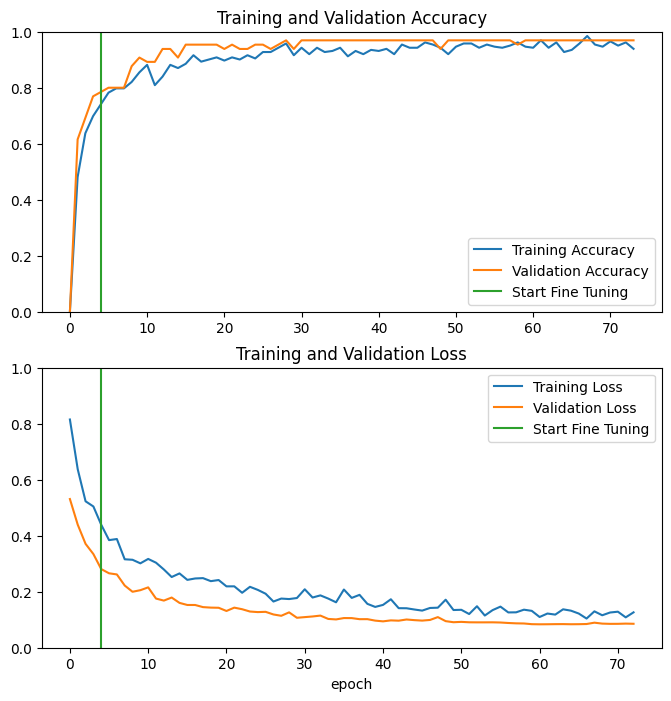

In [75]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


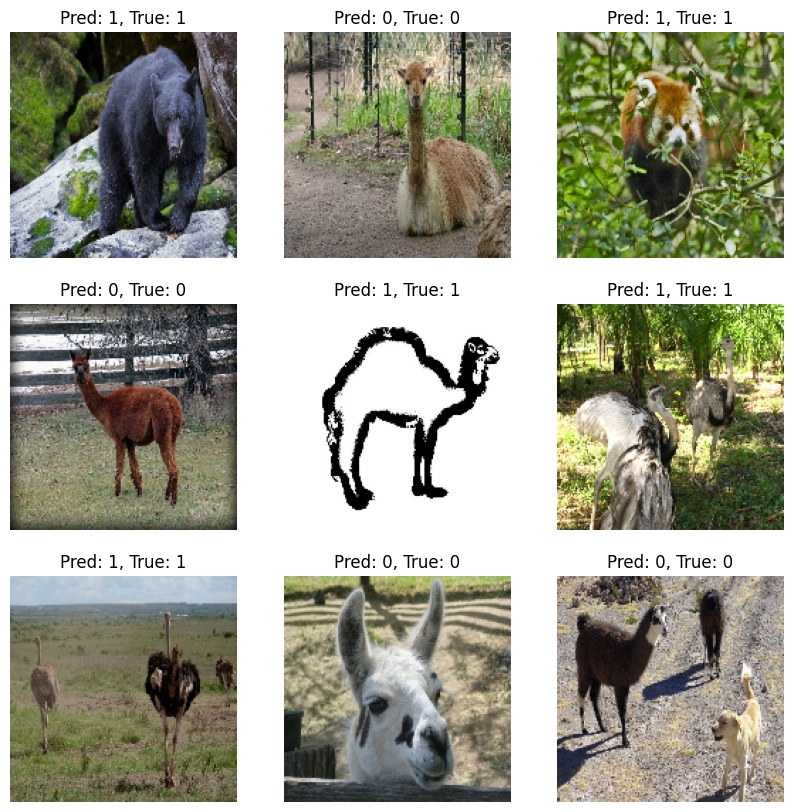

In [72]:
# prompt: model predection and show image with predicted label and true lable

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model2' and 'validation_dataset' are defined from the previous code
# and you have a way to get true labels from validation_dataset

# Example: Get a batch of images and true labels from validation dataset
image_batch, label_batch = next(iter(validation_dataset))

# Make predictions
predictions = model2.predict(image_batch)

# Assuming your model outputs logits, convert to probabilities
probabilities = tf.nn.sigmoid(predictions)

# Get predicted labels (0 or 1)
predicted_labels = (probabilities > 0.5).numpy().astype(int).flatten()


# Display images with predicted and true labels
plt.figure(figsize=(10, 10))
for i in range(9): # Show the first 9 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(f"Pred: {predicted_labels[i]}, True: {label_batch[i]}") # Displaying predicted and actual label
    plt.axis("off")
plt.show()
